# Dowloading all the dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from ipywidgets import IntProgress
from IPython.display import display
import time

max_count = 10

f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar
!pip install -q -U transformers==4.37.2
f.value+=1
!pip install -q neural-compressor
f.value += 1
!pip install -q flash-attn --no-build-isolation
f.value += 1
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0
f.value += 1
!pip install -q langchain
f.value += 1
!pip install -q sentence-transformers
f.value += 1
!pip install -q indic-nlp-library
f.value += 1
!pip install -q -U sacremoses
f.value += 1
!pip install -q urduhack
f.value +=1

IntProgress(value=0, max=10)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.3 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2023.12.0 which is incompatible.
cuml 23.8.0 requires distributed==2023.7.1, but you have distributed 2023.12.0 which is incompatible.
dask-cuda 23.8.0 requires dask==2023.7.1, b

In [3]:
import git

# Clone the repository from the specified URL to the target directory
repo_url = 'https://github.com/VarunGumma/IndicTransTokenizer'
target_directory = '/kaggle/working/sample'

# Clone the repository
git.Repo.clone_from(repo_url, target_directory)

<git.repo.base.Repo '/kaggle/working/sample/.git'>

In [4]:
import sys
# Append the specified directory to the Python sys.path
target_directory = '/kaggle/working/sample'
sys.path.append(target_directory)

In [6]:
!pip install sacrebleu

  Obtaining dependency information for sacrebleu from https://files.pythonhosted.org/packages/de/a5/bf9eddf90deeb7833bbb1ecd7cd4515245cc54c330b936d502ac531f9412/sacrebleu-2.4.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.7 MB/s eta 0:00:00
  Obtaining dependency information for portalocker from https://files.pythonhosted.org/packages/17/9e/87671efcca80ba6203811540ed1f9c0462c1609d2281d7b7f53cef05da3d/portalocker-2.8.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 5.9 MB/s eta 0:00:00


In [7]:
# Import required modules and classes
from transformers import BitsAndBytesConfig  # For quantization of the LLM model
import torch
from IndicTransTokenizer import IndicProcessor, IndicTransTokenizer # For initialization of the translational model
from transformers import AutoModelForSeq2SeqLM # For initialization of the translational model
import transformers  # For the initialization of the LLM Model
from langchain.llms.huggingface_pipeline import HuggingFacePipeline

# Import modules for vector database
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate  # Helps in creating a prompt template
from langchain.document_loaders import PyPDFLoader
from langchain_community.document_loaders import TextLoader

# Additional imports
import torch

In [8]:
from transformers import BitsAndBytesConfig
# Create a quantization configuration using BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Enable 4-bit quantization during model loading
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [9]:
#Initializing the conversation history
conversation_history = []

# Initializing OpenAI Whisper to support Audio to Text for more than 100+ languages
### But it is not that good for Indic languages for which we will be utilizing AI4Bharat Models.

In [10]:
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import load_dataset


device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3"

Whisper_model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, use_safetensors=True,device_map="cuda:0",
    quantization_config=quantization_config
)

Whisper_processor = AutoProcessor.from_pretrained(model_id)

Whisper_pipe = pipeline(
    "automatic-speech-recognition",
    model=Whisper_model,
    tokenizer=Whisper_processor.tokenizer,
    feature_extractor=Whisper_processor.feature_extractor,
    max_new_tokens=128,
    chunk_length_s=30,
    return_timestamps=True,
    torch_dtype=torch_dtype,
)

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Initializing Automatic speech recognition using IndicWav2Vec by AI4Bharat
### As of now we have implemented using only hindi IndicWav2Vec but we can add other indic languages as well.

In [11]:
from transformers import pipeline
transcriber = pipeline("automatic-speech-recognition", model="ai4bharat/indicwav2vec-hindi", device="cuda")

config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

Could not load the `decoder` for ai4bharat/indicwav2vec-hindi. Defaulting to raw CTC. Error: No module named 'kenlm'
Try to install `kenlm`: `pip install kenlm
Try to install `pyctcdecode`: `pip install pyctcdecode


# Initialiazation of the AI4Bharat IndicTrans2
### This model has amazing translational capabilities which will be helpful to us to answer a wide diversity of people

### Indic to English

In [12]:
# Instantiate an IndicTransTokenizer for transliterating from Indic to English
tokenizer_indic_to_en = IndicTransTokenizer(direction="indic-en")

# Instantiate an IndicProcessor for processing transliteration from Indic to English
ip_indic_to_en = IndicProcessor(inference=True)

# Load a pre-trained model for transliteration from Indic to English using AutoModelForSeq2SeqLM
model_indic_to_en = AutoModelForSeq2SeqLM.from_pretrained(
    "ai4bharat/indictrans2-indic-en-1B",
    trust_remote_code=True,
    device_map="cuda:0",
    quantization_config=quantization_config  # Quantization configuration for the model
)

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

configuration_indictrans.py:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-indic-en-1B:
- configuration_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_indictrans.py:   0%|          | 0.00/61.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-indic-en-1B:
- modeling_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/4.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

### English to Indic

In [13]:
# Load the tokenizer using IndicTransTokenizer for transliterating from English to Indic
tokenizer_en_to_indic = IndicTransTokenizer(direction="en-indic")

# Instantiate an IndicProcessor for processing transliteration from English to Indic
ip_en_to_indic = IndicProcessor(inference=True)

# Load a pre-trained model for transliteration from English to Indic using AutoModelForSeq2SeqLM
model_en_to_indic = AutoModelForSeq2SeqLM.from_pretrained(
    "ai4bharat/indictrans2-en-indic-dist-200M",
    trust_remote_code=True,
    device_map="cuda:0"
)

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

configuration_indictrans.py:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-dist-200M:
- configuration_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_indictrans.py:   0%|          | 0.00/61.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-dist-200M:
- modeling_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

# Initialization of LLaVa for visual+textual support

In [14]:
from transformers import pipeline

model_id = "llava-hf/llava-1.5-7b-hf"

VQA_pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

# Initialization of Mistral-Instruct-v0.2

In [15]:
from transformers import pipeline

LLM_pipe = pipeline("text-generation", model="mistralai/Mistral-7B-Instruct-v0.2", model_kwargs={"quantization_config": quantization_config})

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

# Conversation History Tools

In [16]:
def get_history(k=3):
    """
    Retrieve conversation history for contextual understanding.

    Parameters:
    - k (int): The number of conversation tiles to include in the context (default is 3).

    Returns:
    str: A string containing the conversation history up to the specified number of tiles.
    """

    # Initialize an empty string to store the conversation history
    conversation = ""

    # Get the length of the conversation history
    l_conv = len(conversation_history)

    # If the length of the conversation history is greater than k, retrieve the last k tiles
    if l_conv > k:
        for i in range(l_conv - k, l_conv):
            conversation += conversation_history[i]
    else:
        # If the length is less than or equal to k, include the entire conversation history
        for i in conversation_history:
            conversation += i

    # Return the concatenated conversation history string
    return conversation

# Query Processing

### Taking the query from the user

### Convert the query from Indic to English

In [17]:
def translate_indic_to_english(user_input,source_language,target_language):
    # Record the start time for performance measurement
    begin = time.time()
    # Check if the source language is different from the target language for transliteration
    if not (source_language == target_language):
        # Preprocess the user input batch for transliteration
        batch = ip_indic_to_en.preprocess_batch([user_input], src_lang=source_language, tgt_lang=target_language)
        batch = tokenizer_indic_to_en(batch, src=True, return_tensors="pt")

        # Generate transliterations using the pre-trained model
        with torch.inference_mode():
            user_input_translated = model_indic_to_en.generate(
                batch.input_ids.to("cuda"), num_beams=5, num_return_sequences=1, max_length=256
            )

        # Decode the generated sequences and post-process the transliterations
        user_input_translated = tokenizer_indic_to_en.batch_decode(user_input_translated, src=False)
        user_input_translated = ip_indic_to_en.postprocess_batch(user_input_translated, lang=target_language)

        # Print the transliterated user input
        # print(user_input_translated)
    else:
        # If the source and target languages are the same, no transliteration is needed
        user_input_translated = [user_input]
    end = time.time()
    return user_input_translated,end-begin

# Converting English output from the Model back to Hindi

In [18]:
def translate_english_to_indic(en_text,source_language,target_language):
    begin = time.time()
    # Translate English text to Hindi if the source and target languages are different
    if not (source_language == target_language):
        # Preprocess the English text for translation
        batch = ip_en_to_indic.preprocess_batch([en_text], src_lang=target_language, tgt_lang=source_language)
        batch = tokenizer_en_to_indic(batch, src=True, return_tensors="pt")

        # Generate translations using the pre-trained model
        with torch.inference_mode():
            outputs = model_en_to_indic.generate(
                batch.input_ids.to("cuda"), num_beams=2, num_return_sequences=1, max_length=256
            )

        # Decode the generated sequences and post-process the translations
        outputs = tokenizer_en_to_indic.batch_decode(outputs, src=False)
        outputs = ip_en_to_indic.postprocess_batch(outputs, lang=source_language)
    else:
        # If the source and target languages are the same, no translation is needed
        outputs = [en_text]

    # Record the end time for performance measurement
    end = time.time()

    # Measure and print the elapsed time for the operation
    elapsed_time = end - begin
    
    return outputs,elapsed_time

In [19]:
conversation_history = []

In [20]:
import re
from PIL import Image

In [21]:
def conversation(file_path_audio, language_choice, is_audio=False, file_path_image=None, time_it=True):
    """
    Conducts a conversation with the chatbot, translating user input, retrieving context, and generating responses.

    Parameters:
    - user_input (str): The input provided by the user in an Indic language.
    - time_it (bool): A flag indicating whether to print the time taken for each step (default is True).

    Returns:
    None
    """
    # Define a dictionary mapping languages to their corresponding Indic2Trans language codes
    languages = {
        "Assamese":"asm_Beng",
        "Kashmiri (Arabic)":"kas_Arab",
        "Punjabi":"pan_Guru",
        "Bengali":"ben_Beng",
        "Kashmiri (Devanagari)":"kas_Deva",
        "Sanskrit":"san_Deva",
        "Bodo":"brx_Deva",
        "Maithili":"mai_Deva",
        "Santali":"sat_Olck",
        "Dogri":"doi_Deva",
        "Malayalam":"mal_Mlym",
        "Sindhi (Arabic)":"snd_Arab",
        "Marathi":"mar_Deva",
        "English":"eng_Latn",
        "Sindhi (Devanagari)":"snd_Deva",
        "Konkani":"gom_Deva",
        "Manipuri (Bengali)":"mni_Beng",
        "Tamil":"tam_Taml",
        "Gujarati":"guj_Gujr",
        "Manipuri (Meitei)":"mni_Mtei",
        "Telugu":"tel_Telu",
        "Hindi":"hin_Deva",
        "Nepali":"npi_Deva",
        "Urdu":"urd_Arab",
        "Kannada":"kan_Knda",
        "Odia":"ory_Orya"
    }
    # Select the source language for transliteration based on the user's choice
    source_language = languages[language_choice]

    # Set the target language for transliteration to English
    target_language = "eng_Latn"
    # ASR model to convert the audio to text
    if is_audio:
        if language_choice=="English":
            # Will work for all latin languages
            user_input = Whisper_pipe(file_path_audio)
            user_input = user_input["text"]
        else:
            # Specially introduced for Indic Languages
            user_input = transcriber(file_path_audio)
            user_input = user_input["text"]
    else:
        user_input = file_path_audio

    # Translate user input from Indic to English
    user_input_translated, t1_time = translate_indic_to_english(user_input,source_language,target_language)

    # Record the start time for performance measurement
    begin = time.time()
    
    if file_path_image!=None:
        image = Image.open(file_path_image)
        prompt = f"""USER: <image>\nYou are a helpful visual and language assistant who answers to users queries in one to two sentences. {user_input_translated[0]} \nASSISTANT: """
        conversation_history.append({"role": "user", "content": user_input_translated})
        out_pipe = VQA_pipe(image,prompt=prompt, generate_kwargs={"max_new_tokens": 64,"temperature":0.75,"do_sample":True})
        generated_text = out_pipe[0]['generated_text']
        model_reply = ""
        flag = False
        for i in generated_text.split(" "):
            if flag:
                model_reply += i + " "
            if i == "\nASSISTANT:":
                flag = True
    else:
        prompt = f"""<s>[INST] You are a helpful chatbot which answers to users queries in one to two sentences.\n### User Query: {user_input_translated[0]} [/INST]"""
        conversation_history.append({"role": "user", "content": user_input_translated})
        out_pipe = LLM_pipe(prompt, max_new_tokens=128)
        generated_text = out_pipe[0]['generated_text']
        model_reply = ""
        flag = False
        for i in generated_text.split(" "):
            if flag:
                model_reply += i + " "
            if i == "[/INST]":
                flag = True
    
    # Calculate the time taken for the LLM generation
    llm_time = time.time() - begin

    # Update conversation history with user input and assistant response
    conversation_history.append({"role": "assistant", "content": model_reply})

    # Translate the generated English text back to Indic
    output, t2_time = translate_english_to_indic(model_reply,source_language,target_language)

    # Print the translated output
    return output[0]

# Markdown Script

In [22]:
import pathlib
import textwrap

# Import the generative AI module from the google package
import google.generativeai as genai

# Import necessary display modules from IPython
from IPython.display import display, Markdown

def to_markdown(text):
    """
    Convert plain text to Markdown format.

    This function takes a plain text input and converts it to Markdown format.
    It also replaces bullet points with proper Markdown list syntax.

    Args:
        text (str): The plain text to be converted to Markdown.

    Returns:
        Markdown: The converted Markdown text.

    Example:
        >>> plain_text = "This is a bullet point:\n• Item 1\n• Item 2"
        >>> markdown_output = to_markdown(plain_text)
        >>> print(markdown_output)
        > This is a bullet point:
        >   * Item 1
        >   * Item 2
    """
    # Replace special character '•' with proper Markdown list syntax
    text = text.replace('•', '  *')
    
    # Indent the text with '>' to format it as a blockquote
    return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

# Running Samples

In [32]:
%%time
user_input1 = "/kaggle/input/audiotest/Recording.mp3"
to_markdown(conversation(user_input1, is_audio=True, language_choice="Hindi"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


CPU times: user 5.07 s, sys: 83.5 ms, total: 5.16 s
Wall time: 5.25 s


> अपने स्थान के आधार पर निकटतम आधार नामांकन केंद्र खोजने के लिए यू. आई. डी. ए. आई. की वेबसाइट पर आधार नामांकन और अद्यतन लोकेटर का उपयोग करें।

In [33]:
%%time
user_input2 = "Can you give me a cool and rad instagram caption for this image"
to_markdown(conversation(file_path_audio=user_input2, file_path_image="/kaggle/input/imagestotestllava/InstagramGirl.jpg",language_choice="English"))

CPU times: user 4.06 s, sys: 402 ms, total: 4.46 s
Wall time: 4.45 s


> 
> 
> Sure, here is a cool and rad Instagram caption for the image: "Riding a scooter on the beach with the waves in the background. Life is a beach!" 

In [39]:
%%time
user_input3 = "இது எந்த இடத்தின் படம்?"
to_markdown(conversation(file_path_audio=user_input3, file_path_image="/kaggle/input/imagestotestllava/TimesSquareNewYork.jpg",language_choice="Tamil"))

CPU times: user 5.18 s, sys: 352 ms, total: 5.53 s
Wall time: 5.51 s


> இந்த படம் ஒரு பரபரப்பான தெருவைப் பற்றியது, வானளாவிய கட்டிடங்கள் தெருவில் வரிசையாக உள்ளன மற்றும் ஒளிரும் நியான் அடையாளங்கள் இரவில் காட்சியை ஒளிரச் செய்கின்றன.

In [41]:
%%time
user_input4 = "¿Qué se muestra en esta imagen?"
to_markdown(conversation(file_path_audio=user_input4, file_path_image="/kaggle/input/imagestotestllava/SolarSystem.jpg", language_choice="English"))

CPU times: user 2.96 s, sys: 367 ms, total: 3.32 s
Wall time: 3.31 s


>  This image displays the orbits of several planets and moons around a central star, which is the sun. 

In [43]:
%%time
user_input5 = "Can you give me the recipe for mayoniesse"
to_markdown(conversation(file_path_audio=user_input5,language_choice="English"))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


CPU times: user 6.38 s, sys: 83.6 ms, total: 6.46 s
Wall time: 6.46 s


> I'm glad you asked for a mayonnaise recipe! Here it is: In a blender or food processor, combine 1 cup of vegetable oil, 1 egg, 1 tablespoon of mustard, 1 tablespoon of white vinegar or lemon juice, and a pinch of salt. Blend until thick and creamy. Taste and add more salt or acidity if needed. Refrigerate before serving. 

# Future Plans that can be done
We can use Mamba or Jamba models for even faster throughput as it has a complexity of o(n) unlike transformers which have o(n^2) complexity. Qualcomm has also released a Llama version optimised for on mobile-device inference. The results show amazing speed during inference on Samsung Galaxy S23 Ultra with the Snapdragon® 8 Gen 2 Chipset. The model is not currently released on huggingface due to a few errors in uploading quantized versions on HuggingFace.
Reference:
https://huggingface.co/qualcomm/Llama-v2-7B-Chat

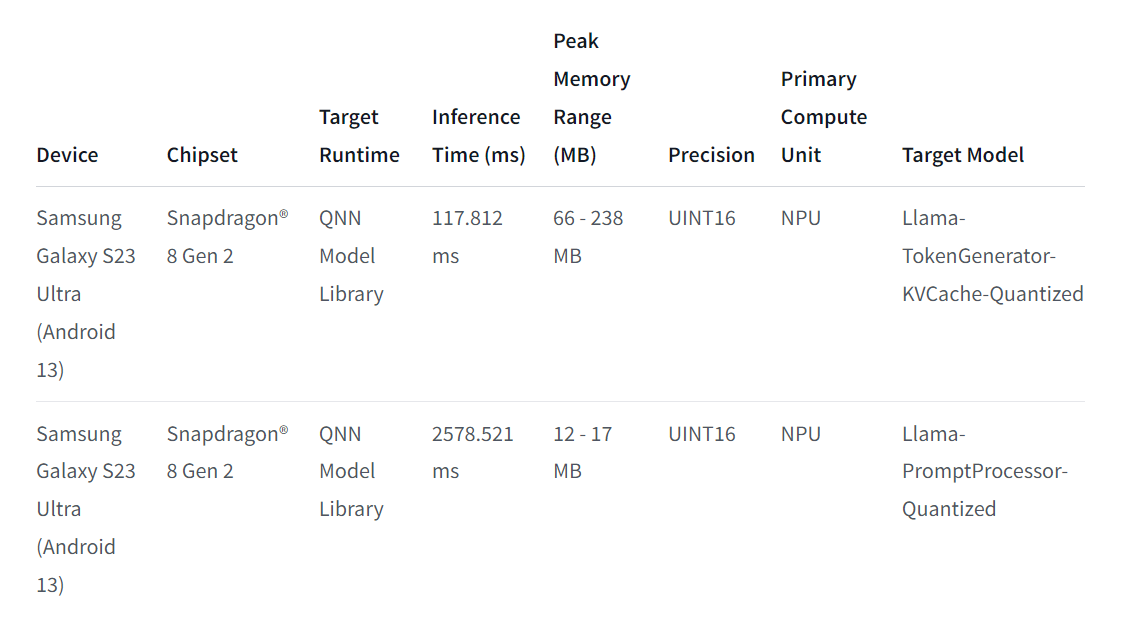